# Workflow

Step 1: Setup AF2Complex by running through the setup module

Step 2: Pick one of three Target Run modules and follow the steps in each module

Step 3: Download your predictions
- After running AF2Complex on a target the prediction location will be printed out Such as the screenshot below. 

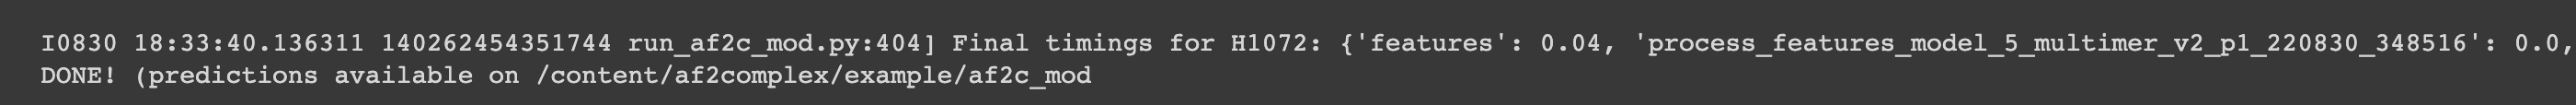

- You can then download these predictions by using Google Colab's file explorer like the GIF below demonstrates:

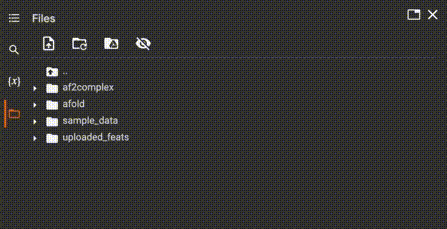


#Setup AF2Complex


In [ ]:
#@title 1. Download deep learning model parameters of AlphaFold 2

#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.

# from google.colab import output
# output.enable_custom_widget_manager()
from IPython.utils import io
import os
import subprocess
import tqdm.notebook
from google.colab import output
import os

output.enable_custom_widget_manager()
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

#SOURCE_URL = "https://storage.googleapis.com/alphafold/alphafold_params_2022-03-02.tar"
SOURCE_URL = "https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar"
PARAMS_DIR = '/content/afold/data/params'

PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      if not os.path.exists(PARAMS_DIR):
          %shell mkdir --parents "{PARAMS_DIR}"
          %shell wget -O "{PARAMS_PATH}" "{SOURCE_URL}"
          pbar.update(40)
  
          %shell tar --extract --verbose --file="{PARAMS_PATH}" \
              --directory="{PARAMS_DIR}" --preserve-permissions
          %shell rm "{PARAMS_PATH}"
          pbar.update(60)
      else:
          pbar.update(100)
except subprocess.CalledProcessError:
  print(captured)
  raise


In [ ]:
#@title 2. Install AF2Complex

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown 
#@markdown This installs AF2Complex and the python packages it uses

import os
import subprocess

AF2C_examples = '/content/af2complex/example'
AF2C_src = '/content/af2complex/src'
AF_LIB_DIR = os.path.join(AF2C_src, 'alphafold')
UPLOAD_DIR = '/content/uploaded_feats/'
os.chdir('/content/')

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
        if not os.path.exists('/content/af2complex'):
            %shell git clone https://github.com/FreshAirTonight/af2complex.git
        pbar.update(15)

        #Install third-party software
        %shell pip uninstall -y tensorflow keras
        pbar.update(5)
        # Install py3dmol.
        %shell pip install py3dmol
        pbar.update(5)
        %shell cd af2complex && pip install -r requirements.txt
        pbar.update(50)
        #%shell pip install --upgrade jax==0.2.14 jaxlib==0.1.69+cuda111 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
        %shell pip3 install --upgrade --no-cache-dir jax==0.3.25 jaxlib==0.3.25+cuda11.cudnn805 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

        if not os.path.exists('/content/uploaded_feats/'):
            %shell mkdir /content/uploaded_feats/
        pbar.update(25)
except subprocess.CalledProcessError:
  print(captured)
  raise



In [ ]:
#@title 3. Define the configuration of your structure prediction run
#@markdown **Note**: Please re-run this cell if any variable below is changed

#@markdown Choose preset model configuration: <deepmind> standard settings according to DeepMind, 
#@markdown  i.e., 3 recycles and 1 ensemble; 
#@markdown - **economy**: no ensemble, up to 256 MSA clusters, recycling up to 3 rounds; 
#@markdown - **super/super2**: 1 or 2 ensembles, up to 512 MSA clusters, recycling up to 20 rounds; 
#@markdown - **genome/genome2**: 1 or 2 ensembles, up to 512 MSA clusters, max number 
#@markdown of recycles and ensembles adjusted according to input sequence length; 
#@markdown - **expert**: similar to super but maintain the same recycle number regardless target size; 
#@markdown - **casp14**: 8 model ensemblings used by DeepMind in CASP14.')
import numpy as np
DATA_DIR =  '/content/afold/data/'
preset = 'economy' #@param ['deepmind', 'casp14', 'economy', 'super', 'expert', 'super2', 'genome', 'genome2']

#@markdown Choose between multimer_v2 or ptm AF parameter sets:
model_type = 'multimer_v3' #@param ['multimer_v3', 'monomer_ptm']
model_preset = {
    'multimer_v3': 'multimer_np',
    'monomer_ptm': 'monomer_ptm',
    }[model_type]
if model_type == 'monomer_ptm':
    model_type = 'ptm'

#@markdown There are five different models you can choose from, check the ones you want to run (please check at least one) 
param_set_1 = True #@param {type:"boolean"}
param_set_2 = False #@param {type:"boolean"}
param_set_3 = False #@param {type:"boolean"}
param_set_4 = False #@param {type:"boolean"}
param_set_5 = False #@param {type:"boolean"}

param_set_nums = [param_set_1,param_set_2,param_set_3,param_set_4,param_set_5]
assert np.any(param_set_nums), 'Please check one of the param_sets '
models = []
for i, param_set in enumerate(param_set_nums):
    if param_set:
        models.append(f"model_{i+1}_{model_type}")

#@markdown Choose your recycling setting:
#@markdown 0. no recycle info saving 
#@markdown 1. print metrics of intermediate recycles
#@markdown 2. additionally saving pdb structures of all recycles, 
#@markdown 3. additionally save all results in pickle
recycling_setting="1" #@param [0, 1, 2, 3]

#@markdown Input below how many predictions (each with a different random seed) will be 
#@markdown generated per model. 

#@markdown E.g. if this is 2 and there are 5
#@markdown models then there will be 10 predictions per input. 
num_predictions_per_model=1 #@param {type:"integer"}

#@markdown Input below the maximum number of recycles. Leave as -1 if you don't want to limit the number of recycles.
max_recycles = 4 #@param {type: "integer"}


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
def make_default_flags():
    return dotdict({
        'target_lst_path':None,
        'output_dir':'/content/af2complex/example/af2c_mod',
        'feature_dir':'/content/af2complex/example/af2c_fea',
        'model_names':None,
        'data_dir':DATA_DIR,
        'preset':'economy',
        'random_seed':None,
        'max_recycles':None,
        'num_ensemble':None,
        'max_msa_clusters':None,
        'max_extra_msa':None,
        'write_complex_features':False,
        'no_template':False,
        'output_pickle':True,
        'save_recycled':0,
        'checkpoint_tag':None,
        'max_mono_msa_depth':10000,
        'mono_msa_crop_size':5000,
        'max_template_hits':4,
        'model_preset':'monomer_ptm',
        'num_predictions_per_model':1,
        'msa_pairing':None,
        'do_cluster_analysis':False,
        'cluster_edge_thres':10,
    })
FLAGS = make_default_flags()
FLAGS['preset'] = preset
FLAGS['model_preset'] = model_preset
FLAGS['model_names'] = models
FLAGS['save_recycled'] = recycling_setting
FLAGS['num_predictions_per_model'] = num_predictions_per_model
FLAGS['max_recycles'] = max_recycles

def make_mod_params():
    preset = FLAGS['preset'] 
    model_preset = FLAGS['model_preset'] 
    models = FLAGS['model_names'] 
    recycling_setting = FLAGS['save_recycled'] 
    target_lst_file = FLAGS['target_lst_file'] 
    msa_pairing = FLAGS['msa_pairing'] 
    out_dir = FLAGS['output_dir']
    fea_dir = FLAGS['feature_dir']
    num_predictions_per_model = FLAGS['num_predictions_per_model']
    max_recycles = FLAGS['max_recycles']

    parameters = [
            f'--target_lst_path={target_lst_file}',
            f'--data_dir={DATA_DIR}',
            f'--output_dir={out_dir}',
            f'--feature_dir={fea_dir}',
            f'--model_names={",".join(models)}',
            f'--preset={preset}',
            f'--model_preset={model_preset}',
            f'--num_predictions_per_model={num_predictions_per_model}',
            f'--save_recycled={recycling_setting}']
        
    if msa_pairing != 'none':
        parameters.append(f'--msa_pairing={msa_pairing}')
    if max_recycles > 0:
        parameters.append(f'--max_recycles={max_recycles}')

    return ' '.join(parameters)

In [ ]:
#@title 4. Define relevant methods for visualization

os.chdir(AF2C_src)
import py3Dmol
from alphafold.data.complex import make_complex_features
from alphafold.model import config
from alphafold.common import confidence
from alphafold.data.complex import initialize_template_feats

import alphafold.data.complex as af2c
from run_af2c_mod import get_asymid2chain_name
import pickle

import numpy as np
import re
import pandas as pd
from ipywidgets import interact, Dropdown
from google.colab import widgets
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from IPython.display import display
import pandas as pd


def show_pdb(pred_output_path, show_sidechains=False, show_mainchains=False):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pred_output_path,'r').read(),'pdb')
  view.setStyle({'cartoon': {'colorscheme': 'chain'}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

def get_asym_id(target, flags):
  """Defines the sequence of preprocessing steps to get the asym_id feature
  Args:
    target: dictionary with the items:
        name: name of the multimer,
        split: information about each monomer composing the multimer,
        full: a string denoting all stoichiometry and domains of all monomers
          composing the multimer to be modeled,
    flags: variable containing inference configuration
  Returns:
    asym_id
  """
  monomers = af2c.load_monomer_feature(target, flags)

  if flags.msa_pairing is not None:
    for i in range(len(monomers)):
        if 'deletion_matrix' in monomers[i]['feature_dict']:
            monomers[i]['feature_dict']['deletion_matrix_int'] = monomers[i]['feature_dict']['deletion_matrix']
  curr_input = {'monomers': monomers, 'target': target, 'flags': flags}

  curr_input = af2c.targeted_domain_cropping_mono(curr_input)
  curr_input = af2c.add_asym_id_monomer_ptm(curr_input)
  asym_id = curr_input['asym_id_mono_ptm']

  return asym_id

def get_interface_score(
    model_name, target_name, full_name, asym_id, idx2chain_name, out_dir, asym_id_list):
        metric = []
        value = []
        pdb_path = os.path.join(out_dir, target_name, f'{model_name}.pdb')
        pkl_path = os.path.join(out_dir, target_name, f'{model_name}.pkl')

        model_config = config.model_config(model_name[:7])
        breaks = np.linspace(
            0., model_config.model.heads.predicted_aligned_error.max_error_bin,
            model_config.model.heads.predicted_aligned_error.num_bins - 1)
        try:
            result = pickle.load(open(pkl_path, "rb"))
        except (EOFError,IOError) as error:
            print(f"Warning: {target_name} {error} encountered, check the pickle file")
            raise

        super_asym_id, superid2chainids = confidence.join_superchains_asym_id(asym_id, asym_id_list)

        res = confidence.interface_score(
            result['aligned_confidence_probs'],
            breaks,
            result['structure_module']['final_atom_positions'],
            result['structure_module']['final_atom_mask'],
            super_asym_id,
            is_probs=True)

        ptm = result['ptm'].tolist()
        pitm = result['pitm']['score'].tolist()

        inter_sc = res['score'].tolist()
        inter_residues = res['num_residues'].tolist()
        inter_contacts = res['num_contacts'].tolist()
        metric.append('MODEL NAME')
        value.append(model_name)
        metric.append('TARGET CHAINS')
        value.append(full_name)
        metric.append('===========')
        value.append('===========')
        metric.append('pTM-score')
        value.append(ptm)
        metric.append('piTM-score')
        value.append(pitm)
        metric.append('iRes')
        value.append(inter_residues)
        metric.append('iCnt')
        value.append(inter_contacts)
        metric.append('interface-score')
        value.append(inter_sc)

        if FLAGS.do_cluster_analysis:
            clus_res = confidence.cluster_analysis(
                super_asym_id,
                result['structure_module']['final_atom_positions'],
                result['structure_module']['final_atom_mask'],
                edge_contacts_thres=FLAGS.cluster_edge_thres,
                superid2chainids=superid2chainids,
            )
            cluster_identities = []
            for cluster in clus_res['clusters']:
                cluster_identities.append([idx2chain_name[c] for c in cluster])

            metric.append('num_clusters')
            value.append(clus_res['num_clusters'])
            metric.append('cluster_sizes')
            value.append(clus_res['cluster_size'])
            metric.append('clusters')
            value.append(cluster_identities)
        return pd.DataFrame({'Metric Name':metric, 'Value':value})

DATA_DIR = '/content/afold/data'  
def display_metrics(target_lst_path, model_path, support, show_sidechains_=True, show_mainchains_=True, ):
    with io.capture_output() as captured:
        target_lst = af2c.read_af2c_target_file(target_lst_path)
        full_name = support["full_name"] 
        target_name= support["target_name"] 
        idx2chain_name= support["idx2chain_name"]
        asym_id_list= support["asym_id_list"]
        asym_id= support["asym_id"] 
        model_name = os.path.basename(model_path)
        pdb_path = os.path.join(FLAGS.output_dir, target_name, f'{model_name}.pdb')

        metrics = get_interface_score(
            model_name, target_name, full_name, asym_id, idx2chain_name, FLAGS.output_dir, asym_id_list
        )

    print(metrics.to_markdown())
    view = show_pdb(pdb_path, 
                show_sidechains=show_sidechains_,
                show_mainchains=show_mainchains_)
    view.show()

def visualize(show_sidechains, show_mainchains):
    is_pdb = lambda x: '.pdb' in x 
    if not os.path.exists(FLAGS.target_lst_file):
        raise f'{FLAGS.target_lst_file} does not exist!'
    target_lst = af2c.read_af2c_target_file(FLAGS.target_lst_file)
    files = []
    model2support = {}
    for target in target_lst:
        target_name = target['name']
        target_name = re.sub(":", "_x", target_name)
        target_name = re.sub("/", "+", target_name)
        target_dir = os.path.join(FLAGS.output_dir, target_name)
        if not os.path.exists(target_dir):
            raise Exception(
                f'No predictions for {target_name}. Predictions available are for {os.listdir(FLAGS.output_dir)}. Please make sure the inference cell was run correctly.'
            )
        target_files = os.listdir(target_dir)
        if len(target_files) == 0:
            raise Exception(
                f'No predictions for {target_name}. Predictions available are for {os.listdir(FLAGS.output_dir)}. Please make sure the inference cell was run correctly.'
            )
        for f in target_files:
            full_name = target['full']
            idx2chain_name = get_asymid2chain_name(target)
            asym_id_list = target['asym_id_list']
            if not FLAGS.write_complex_features:
                with io.capture_output() as captured:
                    asym_id = get_asym_id(target, FLAGS)
            else:
                feat_path = os.path.join(target_name, 'features_comp.pkl')
                try:
                    feature_dict = np.load(open(feat_path, 'rb'))
                except FileNotFoundError:
                    print('Did not find feature_comp.pkl file. ',
                        'To rebuild complex features, run without ',
                        '--write_complex_features flag.')
                asym_id = feature_dict['asym_id']
            if is_pdb(f):
                model_name = os.path.join(target_dir, target_name, f)[:-4]
                files.append(model_name)
                model2support[model_name] = {
                    'full_name': full_name, 
                    'target_name': target_name, 
                    'idx2chain_name': idx2chain_name, 
                    'asym_id_list': asym_id_list, 
                    'asym_id': asym_id, 
                    }

    tabs = widgets.TabBar(files)

    for i, model in enumerate(files): 
        with tabs.output_to(i):
            display_metrics(
                FLAGS.target_lst_file,
                model,
                model2support[model],
                show_sidechains,
                show_mainchains, 
                )

def get_dataset_desc(file_path):
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
    with open(file_path, 'r') as f:
        ecoli_txt = f.readlines()

    ids = []
    genes = []
    acs = []
    fulllen = []
    ranges = []
    length = []
    desc = []
    for line in ecoli_txt:
        if line.startswith('#'):
            continue
        line = line.split('\t')
        ids.append(line[0])
        genes.append(line[1])
        acs.append(line[2])
        fulllen.append(line[3])
        ranges.append(line[4])
        length.append(line[5])
        desc.append(line[6])

    df = pd.DataFrame({
        'ID': ids[1:],
        'Gene': genes[1:],
        'AC': acs[1:],
        'Full Length': fulllen[1:],
        'Range': ranges[1:],
        'Length': length[1:],
        'Description': desc[1:],
    })
    return df

# Target Run (AF2Complex Examples)

In [ ]:
import subprocess
import numpy as np
os.chdir(AF_LIB_DIR)
#@markdown #1. Choose one of the AF2Complex examples to run below! 
#@markdown Note: After choosing your parameters below, press the play button to run the example chosen:
FLAGS['feature_dir'] = '/content/af2complex/example/af2c_fea' 
FLAGS['output_dir'] = '/content/af2complex/example/af2c_mod'

example = 'H1065' #@param ['H1065', 'H1072', 'H1072_H1065', 'H1060v4']

target_lst_file = {
    'H1065': '/content/af2complex/example/targets/example1.lst',
    'H1072': '/content/af2complex/example/targets/example2.lst',
    'H1072_H1065': '/content/af2complex/example/targets/example3.lst',
    'H1060v4': '/content/af2complex/example/targets/example4.lst',
}[example]

#@markdown Choose the type of msa pairing you want to use (Note: 'none' will do no msa_pairing, 'all' will do every possible species pairing as was done in AF-Multimer):
msa_pairing = 'none' #@param ['none', 'all', 'custom', 'cyclic', 'linear']

FLAGS['target_lst_file'] = target_lst_file
FLAGS['msa_pairing'] = msa_pairing

pred_params = make_mod_params()

# with io.capture_output() as captured:
%shell python -u ../run_af2c_mod.py {pred_params}
print(f'DONE! (predictions available on {FLAGS.output_dir}' )

In [ ]:
# %matplotlib inline

#@markdown #2. Visualize your results below by pressing the *Play* button on the left
#@markdown Choose one of the AF2Complex examples to visualize below! 
FLAGS['feature_dir'] = '/content/af2complex/example/af2c_fea' 
FLAGS['output_dir'] = '/content/af2complex/example/af2c_mod'

example = 'H1065' #@param ['H1065', 'H1072', 'H1072_H1065', 'H1060v4']

target_lst_file = {
    'H1065': '/content/af2complex/example/targets/example1.lst',
    'H1072': '/content/af2complex/example/targets/example2.lst',
    'H1072_H1065': '/content/af2complex/example/targets/example3.lst',
    'H1060v4': '/content/af2complex/example/targets/example4.lst',
}[example]

FLAGS['target_lst_file'] = target_lst_file
FLAGS['msa_pairing'] = msa_pairing

pred_params = make_mod_params()

show_sidechains = False #@param {type: 'boolean'}
show_mainchains = False #@param {type: 'boolean'}


AF2C_examples = '/content/af2complex/example'
AF2C_egtargets =  os.path.join(AF2C_examples, 'targets')

visualize(show_sidechains, show_mainchains)

# Target Run (within the *E. coli* by using pre-generated features for the proteome!)

In [ ]:
import os
#@title 1. Download the dataset from [Zenodo](https://zenodo.org/record/7008599#.YwFWR3bMJaQ)
#@markdown Note: Usually takes less than 20 minutes.

AF2C_examples = '/content/af2complex/example'
os.chdir(AF2C_examples)
AF2C_ecoli = os.path.join(AF2C_examples, 'ecoli')
zenodo_link = 'https://zenodo.org/record/7008599/files/af2c_fea_ecoli_220331_msa10ktem10.tar?download=1'

AF2C_ecoli_path = os.path.join(AF2C_ecoli, os.path.basename(zenodo_link))

if not os.path.exists(AF2C_ecoli):
    os.mkdir(AF2C_ecoli)

%shell wget -O {AF2C_ecoli_path} {zenodo_link}
    
with io.capture_output() as captured:
    %shell tar --extract --verbose --file={AF2C_ecoli_path} \
        --directory={AF2C_ecoli} --preserve-permissions
 
AF2C_ecoli_feas = AF2C_ecoli_path.split('.tar')[0]
txt_zenodo_link = "https://zenodo.org/record/7008599/files/ecoli_af2c_fea.txt?download=1"
AF2C_ecoli_txt_path = os.path.join(AF2C_ecoli, os.path.basename(txt_zenodo_link))

%shell wget -O {AF2C_ecoli_txt_path} {txt_zenodo_link}

In [ ]:
import pandas as pd

# @markdown # Find the genes in *E. coli* with pre-generated input features:

ecoli_df = get_dataset_desc(AF2C_ecoli_txt_path)
ecoli_df

In [ ]:
import subprocess
import numpy as np
# from run_af2c_mod import FLAGS
os.chdir(AF_LIB_DIR)
# print(FLAGS.fea_dir, AF2C_ecoli_feas)
FLAGS.feature_dir =  AF2C_ecoli_feas
# print(FLAGS.fea_dir, AF2C_ecoli_feas)
FLAGS.output_dir = '/content/af2complex/example/ecoli/af2c_mod'
if not os.path.exists(FLAGS.output_dir):
    os.mkdir(FLAGS.output_dir)

#@markdown #2. Define your protein complex target using the UniProt IDs you found in the table above, then run AF2Complex using the *Play* button on the left
#@markdown Define how the chains compose the target,
#@markdown e.g.: 
# #@markdown - T1065s1/T1065s2  *(Explanation on [example1](https://github.gatech.edu/gmu3/af2complex/tree/master/example#example-1) for more)*
# #@markdown - T1072s1:2/T1072s2:2 *(Explanation on [example2](https://github.gatech.edu/gmu3/af2complex/tree/master/example#example-2) for more)
# #@markdown - T1065s1/T1065s2+T1072s1:2/T1072s2:2 *(Explanation on [example3](https://github.gatech.edu/gmu3/af2complex/tree/master/example#example-3) for more)*
# #@markdown - T1060s3:12 *(Explanation on [example4](https://github.gatech.edu/gmu3/af2complex/tree/master/example#example-4) for more)*

#@markdown - SECE/SECG/SECY  *(SecYEG translocon, a hetero-trimer composed of SecE, SecG, and SecY, 680 AAs)*
#@markdown - PPID|265-359/DSBA|20-208  *(PpiD parvulin domain and DsbA, each has a residue ID range, 285 AAs)*
#@markdown - SURA|21-428/BAMA|21-420 *(surA and BamA, both have signal peptide removed, 808 AAs)*
#@markdown - PPID/YFGM  *(chaperon proteins PpiD and YfgM, 829 AAs)*
#@markdown - CCMA:2/CCMB:2/CCMC/CCMD/CCME *(CcmI system, 1327 AAs)*
#@markdown - YAJC:3  *(YajC, a membrane protein chaperon? 330 AAs)*

#@markdown Note that a large target may require resources beyond the free-tier.

# chains = 'e.g. T1065s1/T1065s2' #@param {type:'string'}
chains = 'SECE/SECG/SECY' #@param {type:'string'}

#@markdown Name your target
# target = 'e.g. H1065' #@param {type: 'string'}
target = 'SecYEG' #@param {type: 'string'}

#@markdown Put down the total number of AA of the target (does not need to be exact as this number will be parsed but not used in the code)
num_AA = 680 #@param{type: 'integer'}

#@markdown Choose the type of msa pairing you want to use (Note: 'none' will do no msa_pairing, 'all' will do species pairing as in AF-Multimer):
msa_pairing = 'all' #@param ['none', 'all', 'custom', 'cyclic', 'linear']
FLAGS.msa_pairing = msa_pairing

target_lst = f'{chains} {num_AA} {target}'

target_lst_file = os.path.join(AF2C_ecoli, f'{target}.lst')
with open(target_lst_file, 'w') as f:
    f.write(target_lst)
    f.close()
FLAGS.target_lst_file = target_lst_file

pred_params = make_mod_params()

# with io.capture_output() as captured:
%shell python -u ../run_af2c_mod.py {pred_params}
print(f'DONE! (predictions available on {FLAGS.output_dir}' )

In [ ]:
#@markdown # Press **Play** button to the left to see which targets you have predictions for so far
from ipywidgets import interact
pd.DataFrame({
    'Target Name': os.listdir(FLAGS.output_dir),
    'Number of Predictions': [
        len(list(filter(lambda x: '.pdb' in x, os.listdir(os.path.join(FLAGS.output_dir,f )))))
        for f in os.listdir(FLAGS.output_dir)],
})

In [ ]:
#@markdown #3. Visualize your results below by pressing the *Play* button on the left

#@markdown Check out the cell above to see which targets have predictions. Imput the target name below to visualize the proteins. 
target_name = 'SecYEG' #@param {type: 'string'}
FLAGS.target_lst_file = os.path.join(AF2C_ecoli, f'{target_name}.lst')
if not os.path.exists(FLAGS.target_lst_file):
    raise Exception(f' Target: predictions for {target_name} do not exist, run the cell above to see which targets have predictions')

show_sidechains = False #@param {type: 'boolean'}
show_mainchains = False #@param {type: 'boolean'}

visualize(show_sidechains, show_mainchains)

#Target Run (Upload your own features)

First create a folder with your features with the following file structure: 
```
dataset_name
│   
└───chain_1
│   │   
│   └───features.pkl
└───chain_2
│   │   
│   └───features.pkl
...
```
Then, upload a .tar (or .tgz) file of this folder below (Section 1a). You can create a .tar file with the following unix terminal command (Please keep the folder name and the .tar file name the same): 


```
tar -czf af2c_fea.tgz af2c_fea
```


Optionally, you can also upload a txt file describing the dataset to easily search through the dataset. It should look like the following (all tab separated):
```
### ID -- UniProt ID
### Gene -- Recommended gene name
### AC -- Accession ID
### Fulllen -- Full sequence length
### Range -- Residue range of the longest mature chain
### Len -- Seuence length
### Description -- description of the gene
ID	Gene	AC	FullLen	Range	Len	Description
3MG1	tag	P05100	187	1-187	187	DNA-3-methyladenine glycosylase 1
...
```

In [ ]:
#@markdown #1a. Upload your dataset here (press *Play* button to the left)
#@markdown Please upload only one dataset at a time

from google.colab import files
os.chdir(UPLOAD_DIR)
print('Upload the .tar (or .tgz) file')

uploaded = files.upload()
dset_file = list(uploaded.keys())[0]
dset_name = dset_file.split('.')[0]
dset_dir = os.path.join(UPLOAD_DIR, dset_name)
print(f"INFO: Uploaded dataset with name: {dset_name}")
    
with io.capture_output() as captured:
    %shell tar --extract --verbose --file=/content/uploaded_feats/{dset_file} \
        --directory={UPLOAD_DIR} --preserve-permissions
 

In [ ]:
#@markdown #1b. Check out the dataset (Optional)
#@markdown Upload the dataset description file

os.chdir(UPLOAD_DIR)
print('Upload the .txt description file')
uploaded = files.upload()
desc_file = list(uploaded.keys())[0]
dset_df = get_dataset_desc(os.path.join(UPLOAD_DIR, desc_file))
dset_df

In [ ]:
import numpy as np
# from run_af2c_mod import FLAGS
os.chdir(AF_LIB_DIR)
# print(FLAGS.fea_dir, AF2C_ecoli_feas)
FLAGS.feature_dir = os.path.join(UPLOAD_DIR, dset_name)
# print(FLAGS.fea_dir, AF2C_ecoli_feas)
FLAGS.output_dir = os.path.join(UPLOAD_DIR, dset_name, 'af2c_mod')
if not os.path.exists(FLAGS.output_dir):
    os.mkdir(FLAGS.output_dir)

#@markdown #2. Define your protein complex target and Run AF2Complex on it using the *Play* button on the left
#@markdown Define how the chains compose the target, look at sections above for more information (Section 2 of *E. coli* target run)

#@markdown Note that a large target may require resources beyond the free-tier.

# chains = 'e.g. T1065s1/T1065s2' #@param {type:'string'}
chains = 'HgcA/HgcB' #@param {type:'string'}

#@markdown Name your target
# target = 'e.g. H1065' #@param {type: 'string'}
target = 'HgcAB' #@param {type: 'string'}

#@markdown Put down the total number of AA of the target (does not need to be exact as this number will be parsed but not used in the code)
num_AA = 433 #@param{type: 'integer'}

#@markdown Choose the type of msa pairing you want to use (Note: 'none' will do no msa_pairing, 'all' will do species pairing as in AF-Multimer):
msa_pairing = 'all' #@param ['none', 'all', 'custom', 'cyclic', 'linear']
FLAGS.msa_pairing = msa_pairing

target_lst = f'{chains} {num_AA} {target}'

target_lst_file = os.path.join(dset_dir, f'{target}.lst')
with open(target_lst_file, 'w') as f:
    f.write(target_lst)
    f.close()
FLAGS.target_lst_file = target_lst_file

pred_params = make_mod_params()

# with io.capture_output() as captured:
%shell python -u ../run_af2c_mod.py {pred_params}
print(f'DONE! (predictions available on {FLAGS.output_dir}' )

In [ ]:
#@markdown # Press **Play** button to the left to see which targets you have predictions for so far
from ipywidgets import interact
pd.DataFrame({
    'Target Name': os.listdir(FLAGS.output_dir),
    'Number of Predictions': [
        len(list(filter(lambda x: '.pdb' in x, os.listdir(os.path.join(FLAGS.output_dir,f )))))
        for f in os.listdir(FLAGS.output_dir)],
})


In [ ]:
# %matplotlib inline

#@markdown #3. Visualize your results below by pressing the *Play* button on the left

#@markdown Place the target name you want to visualize below
# target = 'e.g. H1065' #@param {type: 'string'}
target_name = 'HgcAB' #@param {type: 'string'}
FLAGS.target_lst_file = os.path.join(dset_dir, f'{target_name}.lst')
if not os.path.exists(FLAGS.target_lst_file):
    raise Exception(f' Target: predictions for {target_name} do not exist, run the cell above to see which targets have predictions')

show_sidechains = False #@param {type: 'boolean'}
show_mainchains = False #@param {type: 'boolean'}

visualize(show_sidechains, show_mainchains)